# Model of regular spiking neuron, with $I_N$ a and $I_K$ for spike generation, and slow $K^+$ current ($I_M$) for spike-frequency adaptation

Imports python packages and set grafical configurations:

In [1]:
# imports 
import os
from matplotlib import pyplot as plt
import numpy as np

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()

Configurations of simulation:

In [2]:
"""
cfg.py 

Simulation configuration for one cell 
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: conrad.bittencourt@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs

cfg = specs.SimConfig()     

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.coreneuron = False
rootFolder = os.getcwd()

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------

cfg.duration = 3000.0 ## Duration of the sim, in ms  
cfg.dt = 0.01 # integration step
cfg.hParams = {'celsius': 36, 'v_init': -84}  

cfg.allpops = []
cfg.allcells = ['sPY'] # Cells 

# Create a population for each cell
for cell in cfg.allcells:
    for i in range(5):
        cfg.allpops.append(f'pop_{cell}_{str(i)}')

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

delaystim = 500
durationstim = 2000

stim0 = 0.150   # stim in nA 
stim1 = 0.200   # stim in nA  
stim2 = 0.250   # stim in nA 

cfg.IClamp0 =   {'pop': cfg.allpops[0], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': stim0}  
cfg.IClamp1 =   {'pop': cfg.allpops[1], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': stim1}   
cfg.IClamp2 =   {'pop': cfg.allpops[2], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': stim2}   
#------------------------------------------------------------------------------
# Record Data 
#------------------------------------------------------------------------------

cfg.recordCells = cfg.allpops  # which cells to record from
## Dict with traces to record
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},  
                    'i_ca': {'sec':'soma_0', 'loc':0.5, 'var':'ica'},
                    'i_m': {'sec':'soma_0', 'loc':0.5, 'var':'im'}}
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = cfg.dt         

cfg.simLabel = 'v0_batch0'
cfg.saveFolder = cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file

NetPyNE parameters:

In [3]:
netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
for cellName in cfg.allcells:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_simple'},
        fileName='cellwrapper_Pospischil2008.py',
        cellName='loadCell',
        cellArgs={'template': cellName},
        cellInstance = True,
        importSynMechs=True
        )

    # observation:
    print(netParams.cellParams[cellName + '_rule']['secs']['soma_0'])

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

# for ith-pop create pop with ith-cell of allcells 
    netParams.popParams[cfg.allpops[0]] = {'cellType': cfg.allcells[0],'cellModel': 'HH_simple','numCells': 1}
    netParams.popParams[cfg.allpops[1]] = {'cellType': cfg.allcells[0],'cellModel': 'HH_simple','numCells': 1}
    netParams.popParams[cfg.allpops[2]] = {'cellType': cfg.allcells[0],'cellModel': 'HH_simple','numCells': 1}
    netParams.popParams[cfg.allpops[3]] = {'cellType': cfg.allcells[0],'cellModel': 'HH_simple','numCells': 1}
    netParams.popParams[cfg.allpops[4]] = {'cellType': cfg.allcells[0],'cellModel': 'HH_simple','numCells': 1}

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop
        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': f'{sec}_0', # target 'soma_0'
            'loc': loc}

Loading cell sPY
Creating a generic sPY cell from Pospischil2008 template
{geom: {L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0}, topol: {}, mechs: {hh2: {gnabar: 0.05, gkbar: 0.005, vtraub: -55.0}, im: {gkbar: 3e-05}, pas: {g: 1e-05, e: -85.0}}, ions: {k: {e: -100.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}}


Run simulations:

In [4]:
from netpyne import sim

sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
# sim.analysis.plotData()         			# plot spike raster etc


Start time:  2023-09-06 13:47:27.571462

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 5 
  Done; cell creation time = 0.01 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 3 
  Done; cell stims creation time = 0.00 s.
Recording 10 traces of 2 types on node 0

Running simulation using NEURON for 3000.0 ms...
  Done; run time = 0.65 s; real-time ratio: 4.64.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 5
  Connections: 0 (0.00 per cell)
  Spikes: 54 (3.60 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 0.65 s


[]

getting data:

In [5]:
# potentials
cell0 = np.array(sim.simData['V_soma']['cell_0'])
cell1 = np.array(sim.simData['V_soma']['cell_1'])
cell2 = np.array(sim.simData['V_soma']['cell_2'])

# time simulation
time = np.array(sim.simData['t'])

# Stims
stim_array0 = np.array([stim0 if t > delaystim and t < cfg.duration - delaystim else 0 for t in time])
stim_array1 = np.array([stim1 if t > delaystim and t < cfg.duration - delaystim else 0 for t in time])
stim_array2 = np.array([stim2 if t > delaystim and t < cfg.duration - delaystim else 0 for t in time])

Plot

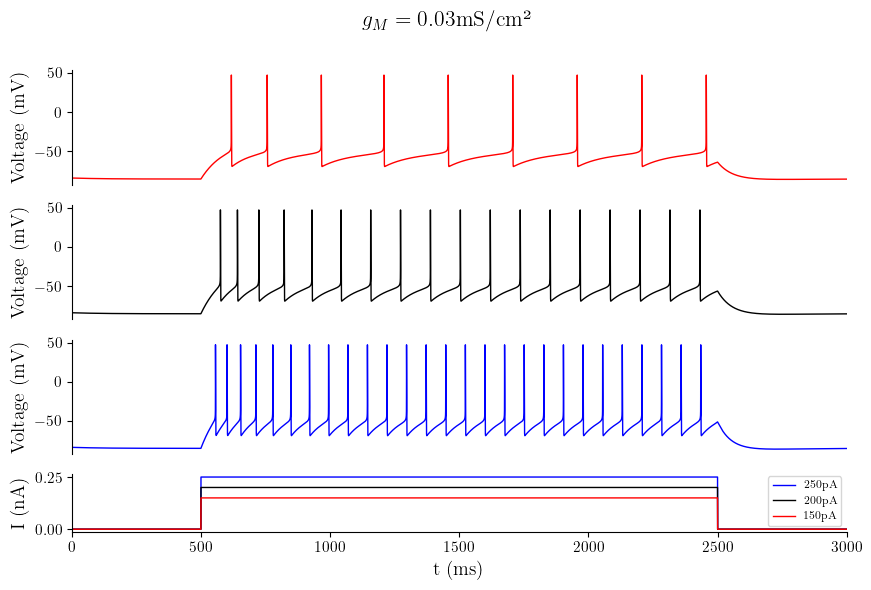

In [6]:
fig, axis = plt.subplots(4,1, figsize=(10,6), gridspec_kw = {'height_ratios':[2, 2, 2, 1]})

fig.suptitle('$g_M = 0.03$mS/cm²')

ax0, ax1, ax2, ax3 = axis

graph_potentials = (ax0, ax1, ax2)

for potential in graph_potentials:
    potential.set_ylabel('Voltage (mV)')
    potential.spines['right'].set_visible(False)
    potential.spines['top'].set_visible(False)
    potential.spines['bottom'].set_visible(False)
    potential.get_xaxis().set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_ylabel('I (nA)')
ax3.set_xlabel('t (ms)')


ax0.plot(time, cell0, color='red')
ax1.plot(time, cell1, color='black')
ax2.plot(time, cell2, color='blue')

ax3.plot(time, stim_array2, color='blue', label=f'250pA')
ax3.plot(time, stim_array1, color='black', label=f'200pA')
ax3.plot(time, stim_array0, color='red', label=f'150pA')


for ax in axis:
    ax.set_xlim(0, 3000)
plt.legend(loc='lower right')

plt.show()